In [1]:
import pydotplus
import os, shutil
import matplotlib.pyplot as plt
import random
import glob
import numpy as np
import tensorflow as tf
from music21 import instrument, note, chord, stream
from PIL import Image
from numpy.random import rand, normal, randn, randint
from numpy import zeros, vstack, asarray, expand_dims, ones
from keras.models import Sequential, load_model
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense, Reshape, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU, ReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator 

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
filelist = glob.glob(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\UBC STUDY\CPSC 540\Project\DATASETS\Working\Train\music\*.png')
trainX = np.array([np.array(Image.open(this_img)) for this_img in filelist])

#filelist2 = glob.glob(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\UBC STUDY\CPSC 540\Project\DATASETS\Working\Train\not_music\*.png')
#trainX2 = np.array([np.array(Image.open(this_img)) for this_img in filelist2])

#trainX2 = trainX2[:, :, :, 0]
#trainX = np.vstack((trainX, trainX2))
print("Size of Training X:", trainX.shape)

filelist = glob.glob(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\UBC STUDY\CPSC 540\Project\DATASETS\Working\Validation\music\*.png')
testX = np.array([np.array(Image.open(this_img)) for this_img in filelist])

#filelist2 = glob.glob(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\UBC STUDY\CPSC 540\Project\DATASETS\Working\Validation\not_music\*.png')
#testX2 = np.array([np.array(Image.open(this_img)) for this_img in filelist2])

#testX2 = testX2[:, :, :, 0]
#testX = np.vstack((testX, testX2))
print("Size of Testing X:", testX.shape)

trainY = []
for i in range(866):
    trainY.append('1')
    
#for i in range(1214):
#    trainY.append('1')

trainY = np.array(trainY)
print("Size of Training Y:", trainY.shape)

testY = []
for i in range(348):
    testY.append('1')
    
#for i in range(519):
#    testY.append('1')

testY = np.array(testY)
print("Size of Testing Y:", testY.shape)

Size of Training X: (866, 106, 106)
Size of Testing X: (348, 106, 106)
Size of Training Y: (866,)
Size of Testing Y: (348,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 106, 106, 128)     1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 106, 106, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 106, 106, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 53, 53, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 53, 53, 1024)      6

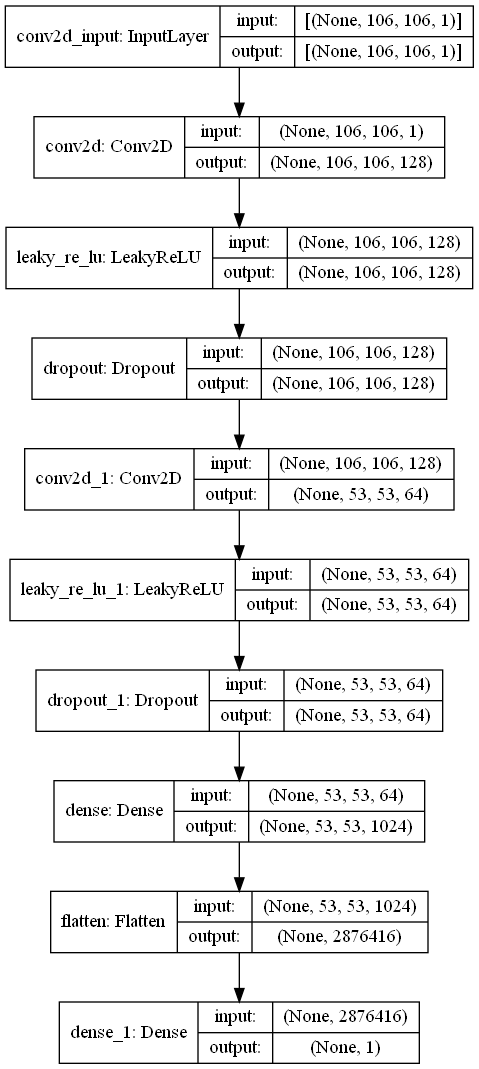

In [4]:
# Defining the discriminator for this GAN

def define_discriminator():
    
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(1, 1), padding='same', input_shape=(106, 106, 1), activation='tanh'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = define_discriminator()
discriminator.summary()
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
def train_preprocessing():
    filelist = glob.glob(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\UBC STUDY\CPSC 540\Project\DATASETS\Working\Train\music\*.png')
    trainX = np.array([np.array(Image.open(this_img)) for this_img in filelist])
    trainX = expand_dims(trainX, axis=-1)
    trainX = trainX.astype('float32')
    trainX = trainX/255.0
    return trainX

def generate_real_samples(dataset, n_samples):
	indices = randint(0, dataset.shape[0], n_samples)
	this_X = dataset[indices]
	this_Y = ones((n_samples, 1))
	return this_X, this_Y

def generate_fake_samples(n_samples):
	X = rand(106 * 106 * n_samples)
	X = X.reshape((n_samples, 106, 106, 1))
	y = zeros((n_samples, 1))
	return X, y

def train_discriminator(model, dataset, n_iter=10, n_batch=64):
    half_batch = int(n_batch / 2)
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

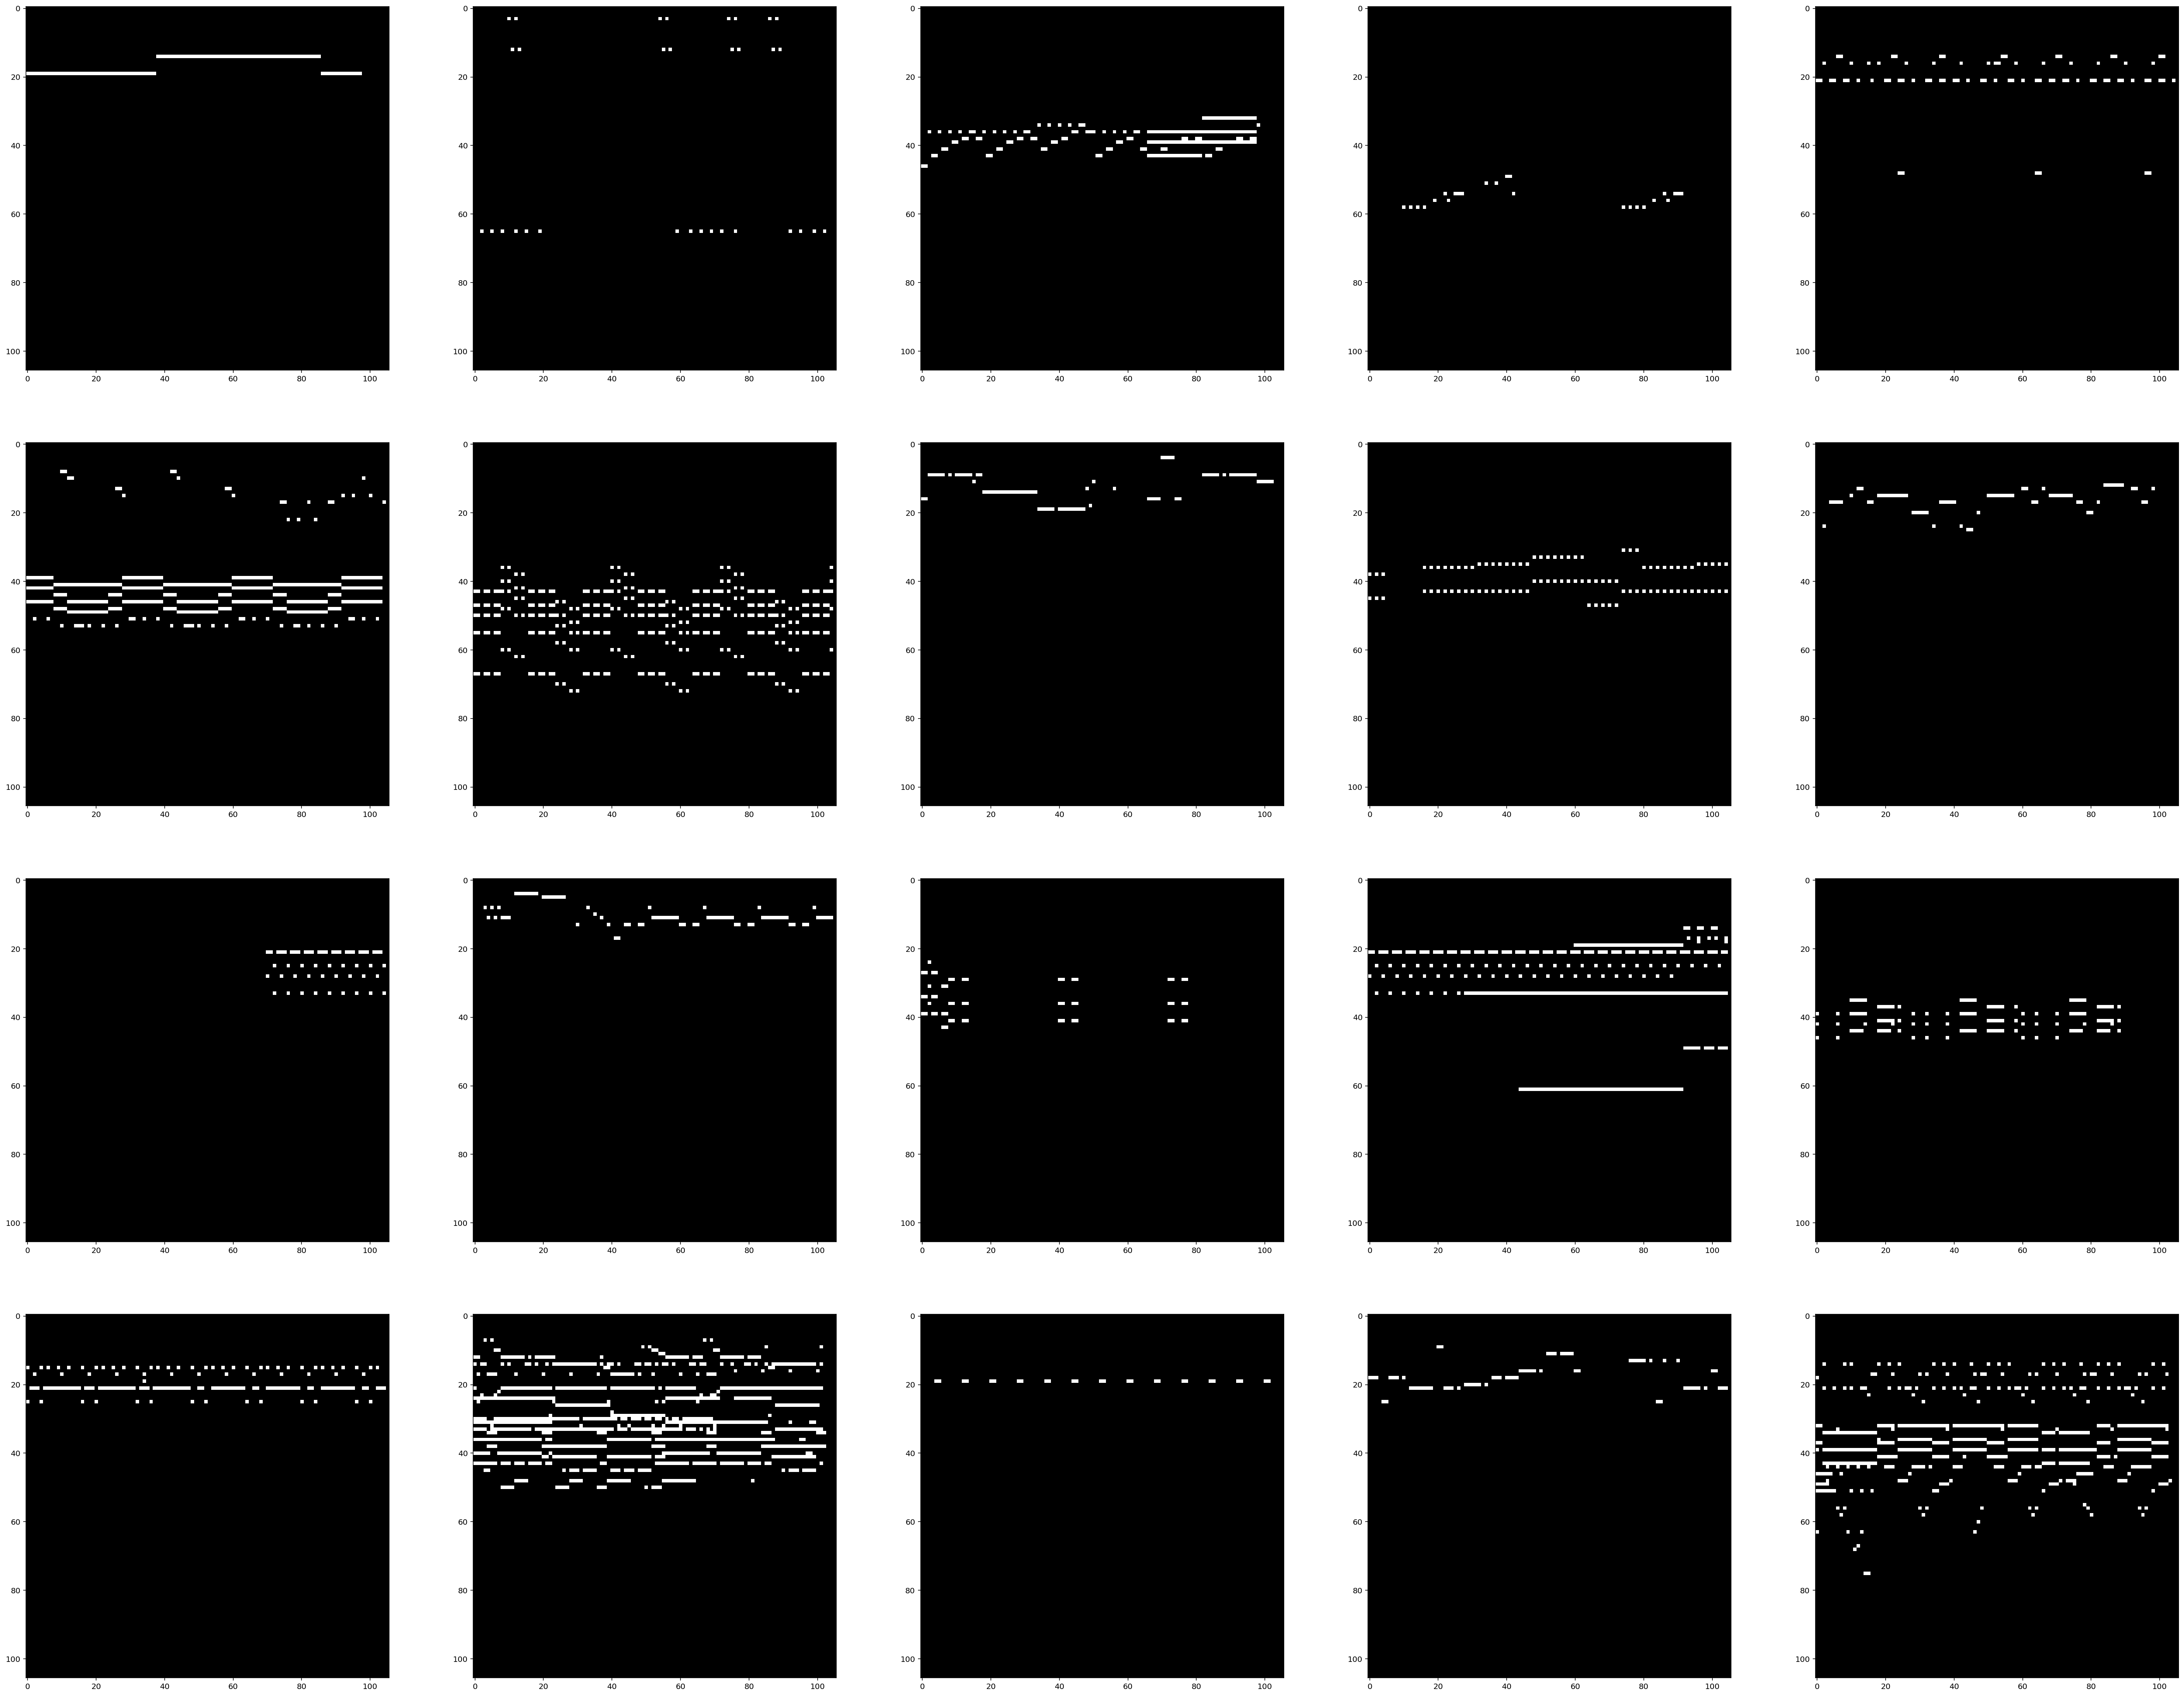

In [6]:
number_of_samples_here = 25
dataset = train_preprocessing()
x_real, y_real = generate_real_samples(dataset, number_of_samples_here)
x_real = x_real.reshape((number_of_samples_here, 106, 106))
plt.figure(figsize=(50,50))
for i in range(20):
    plt.subplot(5, 5, 1 + i)
    plt.imshow(x_real[i], cmap='gray')
plt.show()

In [7]:
discriminator = define_discriminator()
train_discriminator(discriminator, dataset)

>1 real=41% fake=0%
>2 real=97% fake=100%
>3 real=88% fake=100%
>4 real=100% fake=100%
>5 real=100% fake=100%
>6 real=100% fake=100%
>7 real=100% fake=100%
>8 real=100% fake=100%
>9 real=100% fake=100%
>10 real=100% fake=100%


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 179776)            18157376  
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 179776)            0         
_________________________________________________________________
reshape (Reshape)            (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 106, 106, 128)     131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 106, 106, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 1)       359553    
Total params: 18,648,129
Trainable params: 18,648,129
Non-trainable params: 0
__________________________________________

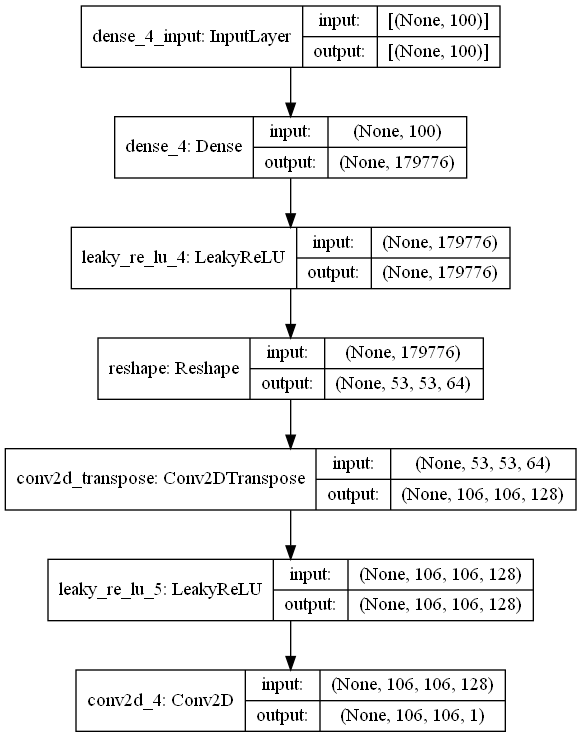

In [8]:
def define_generator(latent_points=100):
    model = Sequential()
    n_nodes = 64 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_points))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 64)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (53,53), activation='tanh', padding='same'))
    #opt = Adam(lr=0.0002, beta_1=0.5)
    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

generator = define_generator()
generator.summary()
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
def generate_latent_points(n_samples, latent_points=100):
    x_input = randn(latent_points * n_samples)
    x_input = x_input.reshape(n_samples, latent_points)
    return x_input

def generate_fake_samples_2(generator, n_samples=16, latent_points=100):
    x_input = generate_latent_points(n_samples, latent_points)
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

n_samples = 10
X, _ = generate_fake_samples_2(generator, n_samples)
plt.figure(figsize=(150,150))
for i in range(n_samples):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray')
plt.show()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 106, 106, 1)       18648129  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 3018049   
Total params: 21,666,178
Trainable params: 18,648,129
Non-trainable params: 3,018,049
_________________________________________________________________


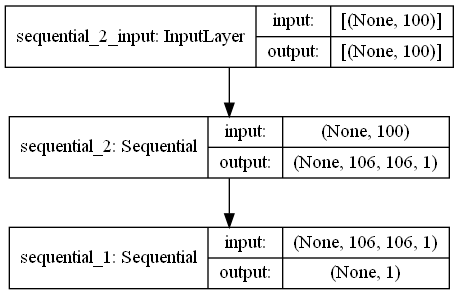

In [10]:
def GAN(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
    return model

gan_model = GAN(generator, discriminator)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()
    
def performance(epoch, generator, discriminator, dataset, n_samples=50):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples_2(generator, n_samples)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    #save_plot(x_fake, epoch)
    #filename = 'generator_model_%03d.h5' % (epoch + 1)
    #generator.save(filename)

def train_GAN(generator, discriminator, gan_model, dataset, n_epochs=10, n_batch=32):
    batch_per_epoch = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples_2(generator, 16)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            discriminator_loss, _ = discriminator.train_on_batch(X, y)
            X_gan = generate_latent_points(n_batch)
            y_gan = ones((n_batch, 1))
            generator_loss = gan_model.train_on_batch(X_gan, y_gan)
            #print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, discriminator_loss, generator_loss))
        
        if (i+1) % 10 == 0:
            performance(i, generator, discriminator, dataset)

In [12]:
generator = define_generator()
gan_model = GAN(generator, discriminator)
train_GAN(generator, discriminator, gan_model, dataset, n_epochs=100)

>Accuracy real: 90%, fake: 100%
>Accuracy real: 98%, fake: 100%
>Accuracy real: 100%, fake: 100%
>Accuracy real: 92%, fake: 100%
>Accuracy real: 100%, fake: 100%
>Accuracy real: 100%, fake: 100%
>Accuracy real: 100%, fake: 100%
>Accuracy real: 98%, fake: 100%
>Accuracy real: 98%, fake: 100%
>Accuracy real: 100%, fake: 100%


In [13]:
os.chdir(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\UBC STUDY\CPSC 540\Project\Jupyter Notebooks\Output\Bare Minimum Model\100 epochs')
model = generator
for i in range(5):
    latent_points = generate_latent_points(1)
    X = generator.predict(latent_points)
    array = np.array(X.reshape(106,106),dtype = np.uint8)
    array*= 255
    new_image = Image.fromarray(array,'L')
    new_image = new_image.save('composition_' + str(i) + '.png')

In [14]:
Image.MAX_IMAGE_PIXELS = None
lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        print(im_arr.shape)
        try:
            im_arr = im_arr.reshape((106, 106))
        except:
            im_arr = im_arr.reshape((106, 106,1))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    offset = 0
    output_notes = []
    
    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))

for file in os.listdir(os.getcwd()):
    image_path = os.getcwd() + '\\' + file
    image2midi(image_path)

(11236,)
(11236,)
(11236,)
(11236,)
(11236,)
